Model k_means on original data:

elbow plot

pairplot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

import os, glob, inspect, sys


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

# Import data

In [ ]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_merge_1.csv'), 
                 index_col=0)


## Calculating new values

In [ ]:
calc_df = mc.updated_df(df, mc.measures_list, mc.errors_list)

## Scaling values

In [ ]:
scaled_df = mc.scale_general(calc_df, MinMaxScaler())[0]


## Selecting sub samples

In [ ]:
mini_df = calc_df.copy().loc[:,mc.minimal_informative_features]
tube_mini, pipe_mini, \
tube_wo_blind_mini, tube_blind_mini = mc.get_subsample_df(mini_df)

In [ ]:
corr_scaled_df = scaled_df.copy().loc[:,mc.correlation_list]
tube_scaled_corr, pipe_scaled_corr, \
tube_wo_blind_scaled_corr, tube_blind_scaled_corr = mc.get_subsample_df(corr_scaled_df)

In [ ]:
mini_scaled_df = scaled_df.copy().loc[:,mc.minimal_informative_features]
tube_scaled_mini, pipe_scaled_mini, \
tube_wo_blind_scaled_mini, tube_blind_scaled_mini = mc.get_subsample_df(mini_scaled_df)

# Clustering

## Elbow method

In [ ]:
min_range = 2
max_range = 8

def plot_elbow_kmeans(feat_norm, title):
    '''
    Elbow plot
    Args:
    - feat_norm : pandas dataframe
    - title : title of the figure ideally correpond to the samples
    return plot
    '''
    
    inertia = []
    k_list = range(min_range, max_range+1)

    for k in k_list:
        km = KMeans(n_clusters = k, random_state= 0)
        km.fit(feat_norm) 
        score = km.inertia_
        inertia.append(score)


    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(min_range , max_range+1) , inertia , 'o')
    plt.plot(np.arange(min_range , max_range+1) , inertia , '-' , alpha = 0.5)

    plt.xlabel('Number of Clusters', fontsize=20) , plt.ylabel('Inertia', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

In [ ]:
# tubes
plot_elbow_kmeans(tube_wo_blind_scaled_corr, title='Identified tubes selected parameters')

In [ ]:
# tubes min
plot_elbow_kmeans(tube_wo_blind_scaled_mini, title='Identified tubes minimal parameters')

## Auto find K
Source: https://jtemporal.com/kmeans-and-elbow-method/

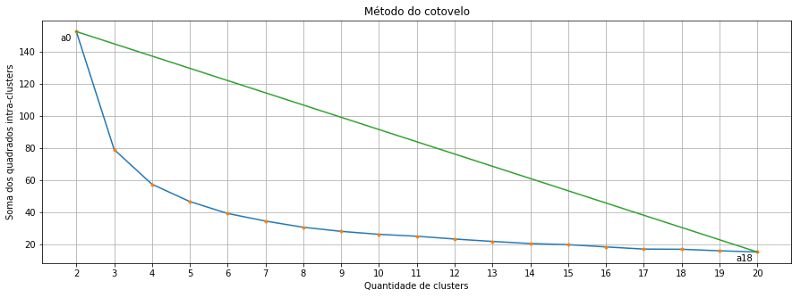

In [ ]:
def calculate_wcss(data):
    '''
    Calculate within class sum-squared value which represents loss in KMeans clustering
    '''
    wcss = []
    for n in range(min_range, max_range):
        kmeans = KMeans(n_clusters=n,random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    return wcss

from math import sqrt

def optimal_number_of_clusters(wcss):
    '''
    Calculate normal distance 
    '''
    x1, y1 = min_range, wcss[0]
    x2, y2 = max_range, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2
    

In [ ]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(tube_wo_blind_scaled_mini)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number of cluster =', n)

In [ ]:
def plot_kmeans(df_scaled, df_ori, k):
    '''
    Scatter plot
    Args:
    - df : scaled pandas dataframe
    - range_col : np.r_[range of column wanted]
    return plot
    '''
    model = KMeans(n_clusters = k, random_state= 42)
    model.fit(df_scaled) 
    labels = model.predict(df_scaled)
    print(labels)
    silhouette = metrics.silhouette_score(df_scaled, labels, metric='euclidean')
    print(silhouette)
    df_ori['labels'] = labels
    sns.pairplot(df_ori, hue='labels')

In [ ]:
plot_kmeans(tube_wo_blind_scaled_mini, tube_wo_blind_mini ,4)

In [ ]:
#test blind sample:
model = KMeans(n_clusters=3, random_state= 42)
model.fit(tube_wo_blind_scaled_mini.iloc[:, :]) 
blind_labels = model.predict(tube_blind_scaled_mini)

In [ ]:
labeled_df = pd.DataFrame()

In [ ]:
labeled_df['labels'] = tube_mini.iloc[8:, -1:].values

In [ ]:
labeled_df['sample'] = tube_wo_blind_scaled_mini.copy().index

In [ ]:
labeled_df['blind'] = blind_labels
labeled_df['blind_t'] = tube_blind_scaled_mini.index

In [ ]:
labeled_df.sort_values('labels')